In [220]:
import numpy as np
from medpy import metric
import pandas as pd
import SimpleITK as sitk
from scipy import ndimage
from surface import Surface
from enum import Enum
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.style.use('seaborn')
#print(plt.style.available)
from IPython.display import display, HTML
from ipywidgets import interact, fixed
%matplotlib inline

In [221]:
# read some files 

In [222]:
reference_segmentation = sitk.ReadImage('tumorSegm', sitk.sitkUInt8)
segmentation = sitk.ReadImage('ablationSegm',sitk.sitkUInt8)
print(reference_segmentation.GetSpacing())
print(reference_segmentation.GetOrigin())
print(reference_segmentation.GetSize())
label = 255



(0.800781, 0.800781, 1.0)
(0.0, 0.0, 0.0)
(51, 51, 49)


In [223]:
class SurfaceDistanceMeasuresITK(Enum):
    hausdorff_distance, max_surface_distance, avg_surface_distance, median_surface_distance, std_surface_distance = range(5)

class SurfaceDistanceMeasuresSurfacePy(Enum):
    hausdorff_distance, avg_symmetric_surface_distance, rms_symmetric_surface_distance = range(3)

class MedpyMetricDists(Enum):
    hausdorff_distance, avg_surface_distance, avg_symmetric_surface_distance = range(3)


In [224]:
surface_distance_results = np.zeros((1,len(SurfaceDistanceMeasuresITK.__members__.items())))
surface_distance_SurfacePy = np.zeros((1,len(SurfaceDistanceMeasuresSurfacePy.__members__.items())))
surface_dists_Medpy = np.zeros((1,len(MedpyMetricDists.__members__.items())))


In [225]:
segmented_surface = sitk.LabelContour(segmentation)

# init signed mauerer distance as reference metrics
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False, useImageSpacing=True))

In [226]:
# init label intensity statistics filter

In [227]:
label_intensity_statistics_filter = sitk.LabelIntensityStatisticsImageFilter()
label_intensity_statistics_filter.Execute(segmented_surface, reference_distance_map)

hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
hausdorff_distance_filter.Execute(reference_segmentation, segmentation)

SimpleITK Metrics

In [228]:
surface_distance_results[0,SurfaceDistanceMeasuresITK.hausdorff_distance.value] = hausdorff_distance_filter.GetHausdorffDistance()
surface_distance_results[0,SurfaceDistanceMeasuresITK.max_surface_distance.value] = label_intensity_statistics_filter.GetMaximum(label)
surface_distance_results[0,SurfaceDistanceMeasuresITK.avg_surface_distance.value] = label_intensity_statistics_filter.GetMean(label)
surface_distance_results[0,SurfaceDistanceMeasuresITK.median_surface_distance.value] = label_intensity_statistics_filter.GetMedian(label)
surface_distance_results[0,SurfaceDistanceMeasuresITK.std_surface_distance.value] = label_intensity_statistics_filter.GetStandardDeviation(label)

surface_distance_results_df = pd.DataFrame(data=surface_distance_results, index = list(range(1)),
                              columns=[name for name, _ in SurfaceDistanceMeasuresITK.__members__.items()])

Plot Mauerer Distances# mauerer distances from simple itk


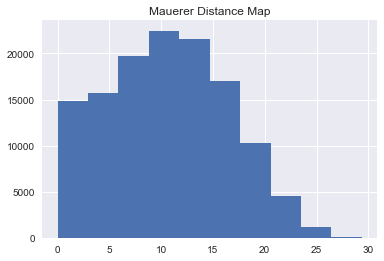

In [229]:
fig, ax= plt.subplots()
plt.hist(reference_distance_map)
plt.title('Mauerer Distance Map')

Convert Image to array to compute the metrics for other libraries

In [230]:
img_array = sitk.GetArrayFromImage(reference_segmentation)
seg_array = sitk.GetArrayFromImage(segmentation)
# reverse array in the order x, y, z
img_array_rev = np.flip(img_array,2)
seg_array_rev = np.flip(seg_array,2)
vxlspacing = segmentation.GetSpacing()

Surface Py Library by Oskar Maier. Used in the Liver and TUMOR CT challenge semgnetation paper by Christ et. al 2017

In [231]:
if np.count_nonzero(img_array)==0 or np.count_nonzero(seg_array)==0:
    surface_distance_SurfacePy[0,SurfaceDistanceMeasuresSurfacePy.hausdorff_distance.value] = 0
    surface_distance_SurfacePy[0,SurfaceDistanceMeasuresSurfacePy.avg_surface_distance.value] = 0
    surface_distance_SurfacePy[0,SurfaceDistanceMeasuresSurfacePy.rms_surface_distance.value] = 0

else:
    evalsurf = Surface(seg_array_rev,img_array_rev, physical_voxel_spacing = vxlspacing , mask_offset = [0.,0.,0.], reference_offset = [0.,0.,0.])
    surface_distance_SurfacePy[0,SurfaceDistanceMeasuresSurfacePy.hausdorff_distance.value] = evalsurf.get_maximum_symmetric_surface_distance()
    surface_distance_SurfacePy[0,SurfaceDistanceMeasuresSurfacePy.avg_symmetric_surface_distance.value] = evalsurf.get_average_symmetric_surface_distance()
    surface_distance_SurfacePy[0,SurfaceDistanceMeasuresSurfacePy.rms_symmetric_surface_distance.value]= evalsurf.get_root_mean_square_symmetric_surface_distance()

surface_distance_SurfacePY_df = pd.DataFrame(data=surface_distance_SurfacePy, index = list(range(1)),
                              columns=[name for name, _ in SurfaceDistanceMeasuresSurfacePy.__members__.items()])

C:\Users\Raluca Sandu\Documents\IGT\SegmentationEvaluation\surface.py:243: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if None == self.__mask_reference_nn:
C:\Users\Raluca Sandu\Documents\IGT\SegmentationEvaluation\surface.py:262: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if None == self.__reference_mask_nn:


C:\Users\Raluca Sandu\Documents\IGT\SegmentationEvaluation\surface.py:262: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if None == self.__reference_mask_nn:


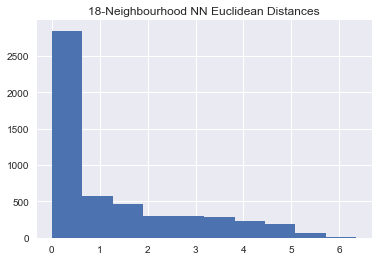

In [232]:
dists_refImgtoMask = evalsurf.get_reference_mask_nn()
fig1, ax= plt.subplots()
plt.hist(dists_refImgtoMask)
plt.title('18-Neighbourhood NN Euclidean Distances') 


MedPy metrics library also by Oskar Maier. Github: https://github.com/loli/medpy

In [254]:
ct = [[[0, 1, 0], [[1, 1, 1],  [[0, 1, 0],
  [1, 1, 1],  [1, 1, 1],   [1, 1, 1],
 [0, 1, 0]], [1, 1, 1]],  [0, 1, 0]]]

surface_dists_Medpy[0,MedpyMetricDists.hausdorff_distance.value] = metric.binary.hd(seg_array_rev,img_array_rev, voxelspacing=vxlspacing, connectivity=ct)
surface_dists_Medpy[0,MedpyMetricDists.avg_surface_distance.value] = metric.binary.asd(seg_array_rev,img_array_rev, voxelspacing=vxlspacing,connectivity=ct)
surface_dists_Medpy[0,MedpyMetricDists.avg_symmetric_surface_distance.value] = metric.binary.assd(seg_array_rev,img_array_rev, voxelspacing=vxlspacing,connectivity=ct)


TypeError: '<' not supported between instances of 'list' and 'int'

In [250]:
# convert to DataFrame
surface_dists_Medpy_df = pd.DataFrame(data=surface_dists_Medpy, index = list(range(1)),
                              columns=[name for name, _ in MedpyMetricDists.__members__.items()])


In [251]:
np.set_printoptions(precision=3)

Simple ITK Library


,hausdorff_distance,max_surface_distance,avg_surface_distance,median_surface_distance,std_surface_distance
0,12.491,7.595,3.120,3.099,1.936


Surface Py Results


,hausdorff_distance,avg_symmetric_surface_distance,rms_symmetric_surface_distance
0,10.862,2.148,3.300


MedPy Library


,hausdorff_distance,avg_surface_distance,avg_symmetric_surface_distance
0,10.862,2.696,3.441


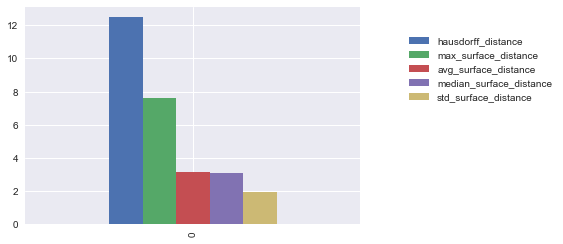

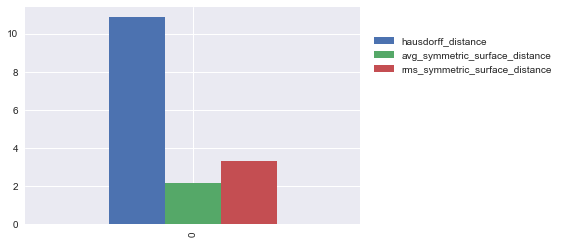

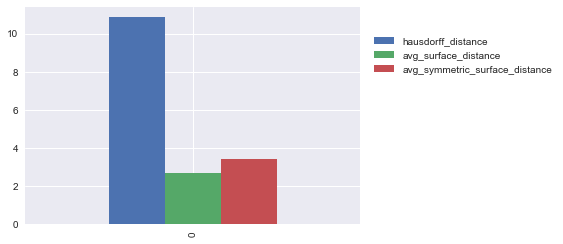

In [252]:
print('Simple ITK Library')
display(HTML(surface_distance_results_df.to_html(float_format=lambda x: '%.3f' % x)))
print('Surface Py Results')
display(HTML(surface_distance_SurfacePY_df.to_html(float_format=lambda x: '%.3f' % x)))
print('MedPy Library')
display(HTML(surface_dists_Medpy_df.to_html(float_format=lambda x: '%.3f' % x)))
surface_distance_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
surface_distance_SurfacePY_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
surface_dists_Medpy_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))

 Display the data as HTML tables and graphs